<a href="https://colab.research.google.com/github/samuelbirchall1/disimpy-sb/blob/master/readmesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install disimpy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 12.0 MB/s 
  Created wheel for disimpy: filename=disimpy-0.2.1-py3-none-any.whl size=1546139 sha256=b3e5191ae0bdcabafcd298283205ef8923c3f52be2c9d58245d3848f667a8181
  Stored in directory: /root/.cache/pip/wheels/c0/2c/b6/2b3ba0359f23b833b09ca594aaf97daf54632fa3ffc7e993f1
Successfully built disimpy


In [1]:
!pip install meshio


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 167 kB 10.6 MB/s 
     |████████████████████████████████| 237 kB 66.2 MB/s 
     |████████████████████████████████| 51 kB 3.0 MB/s 


In [3]:
import disimpy
import meshio
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from disimpy import utils, gradients, substrates, simulations

In [10]:
MESH_PATH = "/content/"

In [14]:

mesh = meshio.read(MESH_PATH + "vascular_mesh_22-10-04_21-52-57_r4_box.ply")
vertices = mesh.points.astype(np.float32)
faces = mesh.cells[0].data


In [17]:
meshio.read("/content/vascular_mesh_22-10-04_21-52-57_r4.ply")

<meshio mesh object>
  Number of points: 238116
  Number of cells:
    triangle: 477676
  Point data: nx, ny, nz

In [19]:
!meshio info "/content/vascular_mesh_22-10-04_21-52-57_r4.ply"

<meshio mesh object>
  Number of points: 238116
  Number of cells:
    triangle: 477676
  Point data: nx, ny, nz


In [31]:
mesh = meshio.read("/content/vascular_mesh_22-10-04_21-52-57_r4.ply")
mesh.points.astype(np.float32)


array([[297.39294 , 257.5011  , 297.311   ],
       [298.48978 , 257.20007 , 298.93143 ],
       [298.4864  , 256.28363 , 296.67584 ],
       ...,
       [293.16147 ,  87.216324, 250.19087 ],
       [275.53955 , 144.69946 , 271.2217  ],
       [233.35439 , 162.36409 , 275.95453 ]], dtype=float32)

In [32]:
vertices = mesh.points.astype(np.float32)
faces = mesh.cells[0].data


In [33]:
faces

array([[    0,     1,     2],
       [    3,     1,     0],
       [    3,     4,     1],
       ...,
       [81275, 81285, 81425],
       [81241, 81292, 81421],
       [81372, 81373, 81370]], dtype=uint32)

In [34]:
vertices


array([[297.39294 , 257.5011  , 297.311   ],
       [298.48978 , 257.20007 , 298.93143 ],
       [298.4864  , 256.28363 , 296.67584 ],
       ...,
       [293.16147 ,  87.216324, 250.19087 ],
       [275.53955 , 144.69946 , 271.2217  ],
       [233.35439 , 162.36409 , 275.95453 ]], dtype=float32)

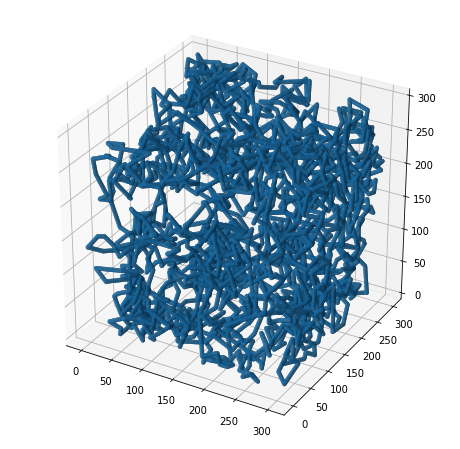

In [35]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.plot_trisurf(
    vertices[:, 0],
    vertices[:, 1],
    vertices[:, 2],
    triangles=faces,
)

In [36]:
substrate = substrates.mesh(
    vertices, faces, padding=np.zeros(3), periodic=True, init_pos="intra"
    )
utils.show_mesh(substrate)

Aligning the corner of the simulated voxel with the origin
Moved the vertices by [3.05005097 3.0756669  3.09149504]
Dividing the mesh into subvoxels
Finished dividing the mesh into subvoxels


KeyboardInterrupt: ignored

/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f8c437598b0> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f8c426474c0> (for post_execute):


KeyboardInterrupt: ignored

In [37]:
min = np.amin(vertices)
max = np.amax(vertices)

In [39]:
vertices = vertices*(1e-6)

In [38]:
min, max

(-3.091495, 303.12527)

In [40]:
vertices

array([[2.9739295e-04, 2.5750109e-04, 2.9731099e-04],
       [2.9848979e-04, 2.5720007e-04, 2.9893144e-04],
       [2.9848638e-04, 2.5628362e-04, 2.9667583e-04],
       ...,
       [2.9316146e-04, 8.7216322e-05, 2.5019087e-04],
       [2.7553955e-04, 1.4469946e-04, 2.7122171e-04],
       [2.3335438e-04, 1.6236409e-04, 2.7595452e-04]], dtype=float32)

In [43]:
substrate = substrates.mesh(
    vertices, faces, padding=np.zeros(3), periodic=True, init_pos="intra"
    )
n_walkers = int(1e3)
diffusivity = 2e-9  # SI units (m^2/s)


gradient = np.zeros((1, 100, 3))
gradient[0, 1:30, 0] = 1
gradient[0, 70:99, 0] = -1
T = 80e-3

n_t = int(1e3)  # Number of time points in the simulation
dt = T / (gradient.shape[1] - 1)  # Time step duration in seconds
gradient, dt = gradients.interpolate_gradient(gradient, dt, n_t)
                                              
bs = np.linspace(0, 3e9, 100)  # SI units (s/m^2)
gradient = np.concatenate([gradient for _ in bs], axis=0)
gradient = gradients.set_b(gradient, dt, bs)


Aligning the corner of the simulated voxel with the origin
Moved the vertices by [3.05005096e-06 3.07566688e-06 3.09149505e-06]
Dividing the mesh into subvoxels
Finished dividing the mesh into subvoxels


Starting simulation
The trajectories file will be up to 0.075 GB
Number of random walkers = 1000
Number of steps = 1000
Step length = 9.802861627917437e-07 m
Step duration = 8.008008008008008e-05 s
Calculating initial positions


/usr/local/lib/python3.8/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 8 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Finished calculating initial positions
Simulation finished


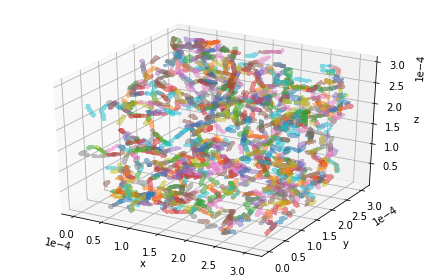

In [44]:
traj_file = "example_traj.txt"
signals = simulations.simulation(
    n_walkers=n_walkers,
    diffusivity=diffusivity,
    gradient=gradient,
    dt=dt,
    substrate=substrate,
    traj=traj_file,
)
utils.show_traj(traj_file)



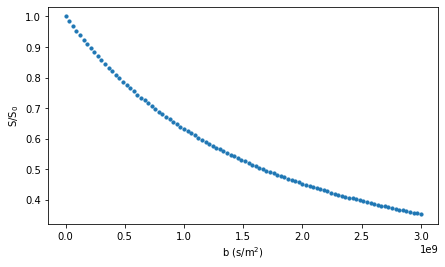

In [45]:
fig, ax = plt.subplots(1, figsize=(7, 4))
ax.scatter(bs, signals / n_walkers, s=10)
ax.set_xlabel("b (s/m$^2$)")
ax.set_ylabel("S/S$_0$")
plt.show()